<h1>AI in Fact and Fiction - Summer 2020</h1>
<h2>Public Emotions - AI Model</h2>


<hr>

<h3>First import the libraries we need:</h3>

We'll use csv for reading csv's and re is to help us substitute characters. We'll need the log function to calculate weights, and pyplot and numpy to create visual representations.

In [1]:
import csv
import re 
from math import log
import matplotlib.pyplot as plt
import numpy as np

Next up is a long block, containing the entire class for our model.

<h2>Initialization:</h2>

model = NaiveSentiment()

<h2>Important functions:</h2>

 .trainCSV(csvfilename, printboolean=False)
    this function will take in the name of a csvfile, and train the data with it.
    The csv should have each line is in the format: string,string,float.
    The first string is the text to train the model with.
    The second string is a tag that can be associated with the text.
    The float is a sentiment rating of the text.
    If printboolean is True, a few statistics will be printed out during the training.

 .analyze(text, printboolean=False)
    The model will provide a shallow sentiment rating of text.
    If printboolean is True, a few statistics will be printed for each word in the text.

 .advancedanalyze(text, printboolean=False)
    The model will provide a deeper sentiment rating of text.
    If printboolean is True, a few statistics will be printed for each word in the text.

 .predicttags(text, printboolean=False)
    The model will provide a analysis of which tags are associated with the text.
    If printboolean is True, a few statistics will be printed for each associated tag.

In [2]:
class NaiveSentiment:
    def __init__(self):
        self.model = {}
        self.model2 = {}
        self.modeltags = {}
        self.modeldocs = {}
        self.docs = 0

    def make_tokens(self, sentence):
        sentence = sentence.upper()
        sentence = re.sub('\n', ' ', sentence)
        for char in sentence:
            if not char.isalpha() and char != " ":
                if (char == "'"):
                    sentence = sentence.replace(char, "")
                else:
                    sentence = sentence.replace(char, " ")
        sentence = sentence.split(" ")
        return list(filter(None, sentence))

    def trainCSV(self, icsv_file, printbool=False):
        with open(icsv_file, newline='\n') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for line in csv_reader:
                self.docs += 1
                words = self.make_tokens(line[0])
                if printbool:
                    print(str(words) + " " + str(float(line[2])))
                for token in words:
                    if token not in self.model:
                        self.model[token] = []
                    self.model[token].append(float(line[2]))
                    if token not in self.modeltags:
                        self.modeltags[token] = {}
                    if line[1] not in self.modeltags[token]:
                        self.modeltags[token][line[1]] = 0
                    self.modeltags[token][line[1]] += 1
                    if token not in self.modeldocs:
                        self.modeldocs[token] = 0
                    self.modeldocs[token] += 1
                    if token not in self.model2:
                        self.model2[token] = {}
                    for token2 in words:
                        if not token == token2:
                            if token2 not in self.model2[token]:
                                self.model2[token][token2] = []
                            self.model2[token][token2].append(float(line[2]))

    def train(self, input):
        for line in input:
            words = self.make_tokens(line)
            for token in words:
                if token not in self.model:
                    self.model[token] = []
                self.model[token].append(input[line])

    def trainadvanced(self, input):
        for line in input:
            self.docs += 1
            words = self.make_tokens(line)
            for token in words:
                if token not in self.model:
                    self.model[token] = []
                self.model[token].append(input[line])
                if token not in self.modeldocs:
                    self.modeldocs[token] = 0
                self.modeldocs[token] += 1
                if token not in self.model2:
                    self.model2[token] = {}
                for token2 in words:
                    if not token == token2:
                        if token2 not in self.model2[token]:
                            self.model2[token][token2] = []
                        self.model2[token][token2].append(input[line])

    def value(self, word):
        if word not in self.model:
            return 0, self.trainedweight(word)
        else:
            v = sum(self.model[word]) / len(self.model[word])
            return v, self.trainedweight(word, v)

    def trainedweight(self, word, value = None):
        if word not in self.modeldocs:
            return 1
        else:
            w = log(self.docs / self.modeldocs[word])
            if w < 0:
                w = 0
            if value != None:
                w = w * value
            return abs(w)

    def advancedvalue(self, word, tokens, veryadvanced = False):
        if veryadvanced:
            print("    " + word)
        if word in self.model2:
            if word not in self.model:
                advancedvalue = 0
                if veryadvanced:
                    print("        " + word + ": 0")
            else:
                if veryadvanced:
                    print("        " + word + ": " + str(sum(self.model[word]) / len(self.model[word])))
                advancedvalue = sum(self.model[word]) / len(self.model[word])
            nums = 1
            for word2 in self.model2[word]:
                if word2 in tokens:
                    if veryadvanced:
                        print("        " + word + ", " + word2 + ": " + str(sum(self.model2[word][word2]) / len(self.model2[word][word2])))
                    advancedvalue += (sum(self.model2[word][word2]) / len(self.model2[word][word2]))
                    nums += 1
            v = advancedvalue / nums
            w = self.trainedweight(word, v)
            if veryadvanced:
                print("    Word value in this context: " + str(v))
                print("    Word weight in this context: " + str(w))
            return v, w
        else:
            if word not in self.model:
                if veryadvanced:
                    print("        " + word + ": 0")
                return 0, self.trainedweight(word, 0)
            else:
                v = sum(self.model[word]) / len(self.model[word])
                w = self.trainedweight(word, v)
                if veryadvanced:
                    print(word + " " + str(self.model[word]))
                    print("        " + word + ": " + str(v))
                    print("    Word weight in context: " + str(w))
                return v, self.trainedweight(word, v)

    def analyze(self, text, weighted=True):
        sentiment = [];
        weights = [];
        text = self.make_tokens(text)
        for word in text:
                t = self.value(word)
                sentiment.append(t[0])
                print("    " + word + " " + str(t[0]))
                if weighted:
                    weights.append(t[1])
                    print("    weight: " + str(t[1]))
        value = 0
        for i in range(len(sentiment)):
            value += sentiment[i] * weights[i]
        value = value / sum(weights)
        return value

    def advancedanalyze(self, text, printbool = False):
        plt.rcParams["figure.figsize"] = (15,5)
        sentiment = [];
        weights = [];
        text = self.make_tokens(text)
        data_word = []
        for word in text:
            t = self.advancedvalue(word, text, printbool)
            sentiment.append(t[0])
            weights.append(t[1])
            data_word.append(word)
        value = 0
        
        data_value = []
        for i in range(len(sentiment)):
            value += sentiment[i] * weights[i]
            data_value.append(sentiment[i] * weights[i] / sum(weights))      
        

        plt.title('Sentiment of Text')
        plt.xlabel('Words')
        plt.ylabel('Sentiment')
        
        plt.scatter(data_word, data_value, c=data_value)
        plt.colorbar()

        plt.show()
        value = value / sum(weights)
        return value

    def predicttags(self, text, printbool = False):
        tags = {}
        text = self.make_tokens(text)
        for word in text:
            if word not in self.modeltags:
                continue
            for tag in self.modeltags[word]:
                if tag not in tags:
                    tags[tag] = [0, []]
                tags[tag][0] += self.modeltags[word][tag]
                tags[tag][1].append(word)
        maxval = 0
        maxtag = None
        if not printbool:
            normalizer = 0
            for vals in tags.values():
                normalizer += vals[0]
            if normalizer == 0:
                normalizer = 1
        for tag in tags.keys():
            if printbool:
                print("    Tag: " + tag + " - " + str(tags[tag][0]))
                for word in tags[tag][1]:
                    print("        " + word)
            else:
                print("    Tag: " + tag + " - " + str(round(tags[tag][0] / normalizer * 100, 2)) + "%")
            if tags[tag][0] > maxval:
                maxval = tags[tag][0]
                maxtag = tag
        print("Most likely tag: " + maxtag)

<h2>With the class created, we can now test it.</h2>

First, we'll need some data to train it with, most of which we have gathered from twitter.


Here is an example training set in the form of a dictionary, with a special train function that we wrote for it.


In [3]:
trainingset = {"hello, my friend, you are very strong!!":1,
               "you are a handsome man":1,
               "sometimes i like to drink milk":0.3,
               "my friend is sometimes handsome":0.2,
               "I hate coronavirus":-0.8,
               "masks are really stupid":-0.7,
               "coronavirus is bad, even worse than masks":-1,
               "you are handsome, coronavirus is not handsome":0,
               "milk is preventitive of coronavirus":0.5,
               "my friend is pretty strong":0.4,
               "my friend is literally coronavirus incarnate":-0.8,
               "masks makes me hate coronavirus more than i do now":-0.9,
               "hate worse awful coronavirus":-1,
               "this coronavirus thing is really strong":-0.5,
               "milk is good for you":0.1,
               "my friend is a good person":0.8,
               "my friend is really stupid":-0.5,
               "masks are good for you":0.6,
               "my friend is good at drinking milk":0.7,
               "coronavirus is too goddamn strong, i hate it":-1,
               "worse than masks are coronavirus, I hate it!":-1,
               "coronavirus is hate awful":-1,
               "milk tastes so handsome, you know?":0.7,
               "i think people hate masks more than coronavirus sometimes":-0.7,
               "bad is so bad": -0.6,
               "good things are good": 0.6,
               "good is so good": 0.9,
               "i like good things": 0.8,
               "being strong is good": 0.7,
               "i like being strong": 0.7,
               "i am a big fan of milk": 0.8,
               "i like handsome person": 0.4,
               "i hate certain things": -0.7,
               "I really like my friends": 0.9}

Here is an example use of our model, starting with the initialization, and the training using a few csv files that we had prepared in advance.
We also train it with the example training set that we made by hand, though only to offset a few strangely skewed values that we know.

In [4]:
model = NaiveSentiment()
#model.trainCSV("test1.csv")# somewhat skewed
model.trainCSV("test2.csv") # slightly skewed
model.trainCSV("test3.csv") # mostly unskewed
model.trainCSV("test4.csv") # mostly unskewed
model.trainadvanced(trainingset)

<h2>Test cases</h2>

Ahead are a several examples of advancedanalyze, using the model we just trained.

sentence:  people hate masks more than coronavirus
    PEOPLE
        PEOPLE: 0.03559130908078276
        PEOPLE, CORONAVIRUS: -0.00022806057288817105
        PEOPLE, MORE: 0.19294126157407412
        PEOPLE, THAN: 0.019745370370370385
        PEOPLE, MASKS: -0.011805555555555555
        PEOPLE, HATE: -0.7
    Word value in this context: -0.07729261251720274
    Word weight in this context: 0.20354254142181327
    HATE
        HATE: -0.5555555555555555
        HATE, CORONAVIRUS: -0.9142857142857144
        HATE, MASKS: -0.8666666666666666
        HATE, MORE: -0.8
        HATE, THAN: -0.8666666666666666
        HATE, PEOPLE: -0.7
    Word value in this context: -0.7838624338624339
    Word weight in this context: 3.5936874667109935
    MASKS
        MASKS: -0.013866213151927449
        MASKS, PEOPLE: -0.011805555555555555
        MASKS, CORONAVIRUS: -0.36851851851851847
        MASKS, THAN: -0.6827777777777777
        MASKS, HATE: -0.8666666666666666
        MASKS, MORE: -0.8
    Word v

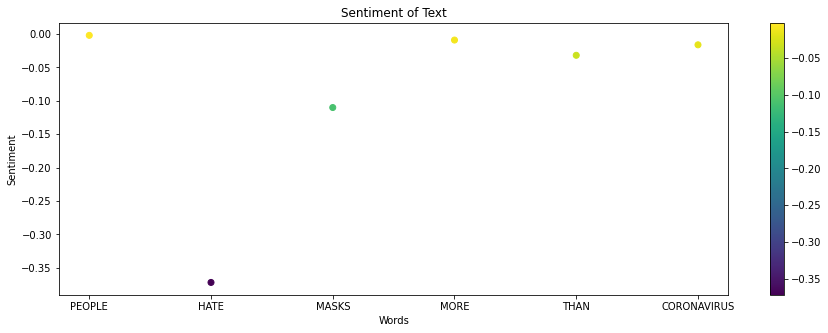

Overall sentence sentiment:  -0.5413203287853853


In [5]:
str1 = "people hate masks more than coronavirus"
print("sentence: ", str1)
analyze1 = model.advancedanalyze(str1, True)
print("Overall sentence sentiment: ", analyze1)

corona is so bad
    CORONA
        CORONA: 0.006660010737694912
        CORONA, IS: -0.034356962481962475
        CORONA, BAD: -0.4416666666666666
        CORONA, SO: 0.2802348976780796
    Word value in this context: -0.047282180183213646
    Word weight in this context: 0.0672394239341218
    IS
        IS: 0.047481246541864926
        IS, CORONA: -0.034356962481962475
        IS, SO: 0.06520079495915529
        IS, BAD: -0.5231687242798353
    Word value in this context: -0.1112109113151944
    Word weight in this context: 0.1588511512278126
    SO
        SO: 0.10830228621884569
        SO, CORONA: 0.2802348976780796
        SO, IS: 0.06520079495915529
        SO, BAD: -0.597037037037037
    Word value in this context: -0.03582476454523911
    Word weight in this context: 0.09896349502655372
    BAD
        BAD: -0.4940760030864197
        BAD, CORONA: -0.4416666666666666
        BAD, SO: -0.597037037037037
        BAD, IS: -0.5231687242798353
    Word value in this context: -0.51

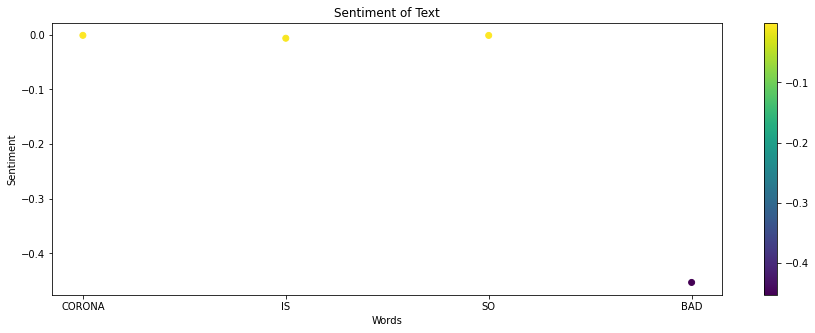

Overall sentence sentiment:  -0.4619512297831319


In [6]:
str2 = "corona is so bad"
print(str2)
analyze2 = model.advancedanalyze(str2, True)
print("Overall sentence sentiment: ", analyze2)

stay home, and stay safe!
    STAY
        STAY: 0.3318991960420533
        STAY, AND: 0.37341991341991365
        STAY, HOME: 0.42956228956228976
        STAY, SAFE: 0.47523191094619666
    Word value in this context: 0.40252832749261336
    Word weight in this context: 1.7409665274513102
    HOME
        HOME: 0.11730687355434592
        HOME, STAY: 0.42956228956228976
        HOME, SAFE: 0.5
        HOME, AND: 0.17630172448834422
    Word value in this context: 0.305792721901245
    Word weight in this context: 1.0512466013832906
    AND
        AND: 0.08958373831618814
        AND, STAY: 0.37341991341991365
        AND, HOME: 0.17630172448834422
        AND, SAFE: 0.38152022874245095
    Word value in this context: 0.2552064012417242
    Word weight in this context: 0.322673061298932
    STAY
        STAY: 0.3318991960420533
        STAY, AND: 0.37341991341991365
        STAY, HOME: 0.42956228956228976
        STAY, SAFE: 0.47523191094619666
    Word value in this context: 0.402528

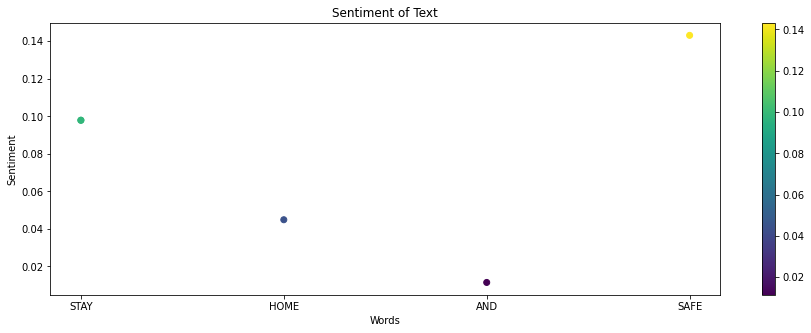

Overall sentence sentiment:  0.39535159625465244


In [7]:
str3 = "stay home, and stay safe!"
print(str3)
analyze3 = model.advancedanalyze(str3, True)
print("Overall sentence sentiment: ", analyze3)

I want my stimulus check
    I
        I: 0.06113383453605594
        I, WANT: 0.372718253968254
        I, MY: 0.07940658644448541
        I, CHECK: -0.25
    Word value in this context: 0.06581466873719882
    Word weight in this context: 0.10420548546411969
    WANT
        WANT: 0.29505333255333255
        WANT, I: 0.372718253968254
        WANT, CHECK: 0.0
        WANT, MY: 0.04375
    Word value in this context: 0.17788039663039662
    Word weight in this context: 0.6361645578371559
    MY
        MY: 0.06531665152463471
        MY, I: 0.07940658644448541
        MY, WANT: 0.04375
    Word value in this context: 0.06282441265637338
    Word weight in this context: 0.15594675541558703
    STIMULUS
        STIMULUS: 0
    CHECK
        CHECK: 0.011529839208410636
        CHECK, I: -0.25
        CHECK, WANT: 0.0
    Word value in this context: -0.07949005359719645
    Word weight in this context: 0.4166367038993707


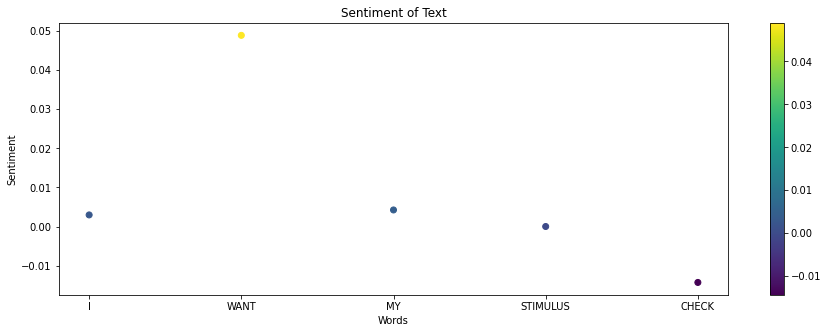

Overall sentence sentiment:  0.041807257542552316


In [8]:
str4 = "I want my stimulus check"
print(str4)
analyze4 = model.advancedanalyze(str4, True)
print("Overall sentence sentiment: ", analyze4)

Weather is so gorgeous but we still have Corona out here...
    WEATHER
        WEATHER: -0.05
        WEATHER, IS: 0.7
        WEATHER, SO: 0.7
        WEATHER, GORGEOUS: 0.7
        WEATHER, BUT: 0.7
        WEATHER, WE: 0.7
        WEATHER, STILL: 0.7
        WEATHER, HAVE: 0.7
        WEATHER, CORONA: 0.7
        WEATHER, OUT: 0.7
        WEATHER, HERE: 0.7
    Word value in this context: 0.631818181818182
    Word weight in this context: 4.103110662095359
    IS
        IS: 0.047481246541864926
        IS, OUT: 0.10035818713450291
        IS, CORONA: -0.034356962481962475
        IS, WE: -0.019080372889896693
        IS, HAVE: 0.11014734934377793
        IS, SO: 0.06520079495915529
        IS, WEATHER: 0.7
        IS, GORGEOUS: 0.7
        IS, BUT: 0.1195889227370709
        IS, STILL: 0.14268849206349207
        IS, HERE: 0.03293613215488215
    Word value in this context: 0.17863307177844429
    Word weight in this context: 0.25515544080870617
    SO
        SO: 0.10830228621884

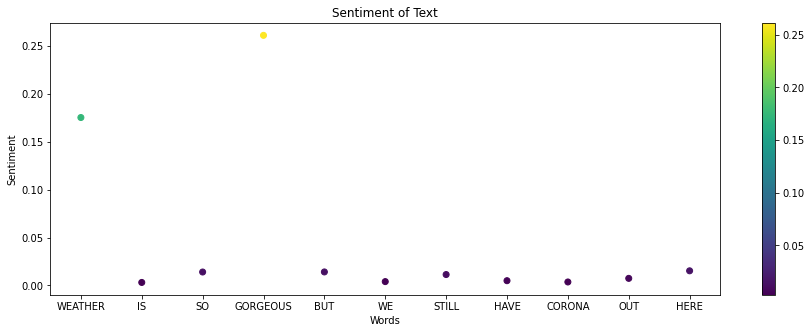

Overall sentence sentiment:  0.5139805797439144


In [9]:
str5 = "Weather is so gorgeous but we still have Corona out here..."
print(str5)
analyze5 = model.advancedanalyze(str5, True)
print("Overall sentence sentiment: ", analyze5)

corona is destroying everything and I’m so sad
    CORONA
        CORONA: 0.006660010737694912
        CORONA, IS: -0.034356962481962475
        CORONA, AND: 0.09922447203697213
        CORONA, I: -0.018110622199437976
        CORONA, M: -0.16646068984778672
        CORONA, SO: 0.2802348976780796
        CORONA, EVERYTHING: -0.09634920634920635
    Word value in this context: 0.01012027136776473
    Word weight in this context: 0.014391917085648161
    IS
        IS: 0.047481246541864926
        IS, CORONA: -0.034356962481962475
        IS, AND: 0.10395258096563953
        IS, I: 0.1974738928399644
        IS, SO: 0.06520079495915529
        IS, M: 0.010819327731092437
        IS, EVERYTHING: -0.20000000000000004
        IS, SAD: -0.4083333333333334
    Word value in this context: -0.027220306597197413
    Word weight in this context: 0.03888087048836241
    DESTROYING
        DESTROYING: 0
    EVERYTHING
        EVERYTHING: -0.1867063492063492
        EVERYTHING, I: -0.014550264550264

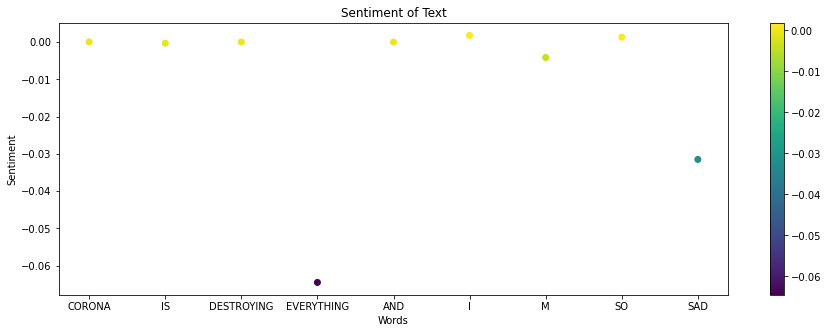

Overall sentence sentiment:  -0.09729178877451616


In [10]:
str6 = "corona is destroying everything and I’m so sad"
print(str6)
analyze6 = model.advancedanalyze(str6, True)
print("Overall sentence sentiment: ", analyze6)

Here is an example of the "preddicttags" function, once with False for the print boolean, and once with True.

In [11]:
print("Tags for: 'Weather is so gorgeous but we still have Corona out here..'")
model.predicttags("Weather is so gorgeous but we still have Corona out here..")
print()
model.predicttags("Weather is so gorgeous but we still have Corona out here..", True)

Tags for: 'Weather is so gorgeous but we still have Corona out here..'
    Tag: March - 50.29%
    Tag: August - 23.36%
    Tag: June - 26.35%
Most likely tag: March

    Tag: March - 1210
        WEATHER
        IS
        SO
        GORGEOUS
        BUT
        WE
        STILL
        HAVE
        CORONA
        OUT
        HERE
    Tag: August - 562
        IS
        SO
        BUT
        WE
        STILL
        HAVE
        CORONA
        OUT
        HERE
    Tag: June - 634
        IS
        SO
        BUT
        WE
        STILL
        HAVE
        CORONA
        OUT
        HERE
Most likely tag: March


<h2 id="Graph">Data Visualization</h2>

Label each score from the inputed senitment as positive, negative, or neutral.

In [12]:
def scoreLabel(score):
  if score < -0.2:
    return 'Negative'
  elif score > -0.2 and score < 0.2:
    return 'Neutral'
  else:
    return 'Positive'

data_sentiment = []
data_sentiment.append(scoreLabel(analyze1))
data_sentiment.append(scoreLabel(analyze2))
data_sentiment.append(scoreLabel(analyze3))
data_sentiment.append(scoreLabel(analyze4))
data_sentiment.append(scoreLabel(analyze5))
data_sentiment.append(scoreLabel(analyze6))

data_sentiment

['Negative', 'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral']

Graphing the sentiment of the current tweet topic by counting the number of distinct outputs.

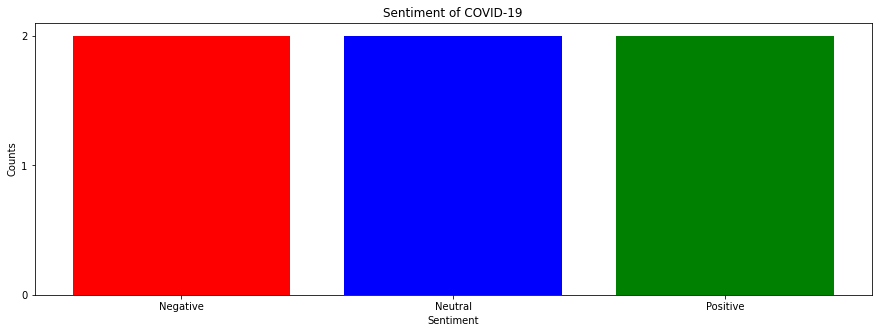

In [13]:
numPos = int(data_sentiment.count('Positive'))
numNeg = int(data_sentiment.count('Negative'))
numNeu = int(data_sentiment.count('Neutral'))

count_arr = [numNeg, numNeu, numPos]

plt.title('Sentiment of COVID-19')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

y_ticks = np.arange(0, len(data_sentiment), 1)
plt.yticks(y_ticks)

types = ['Negative', 'Neutral', 'Positive']

plt.bar(types, count_arr, color=['red','blue','green'])

plt.show()